<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;"> TFM Ciencia Datos</p>
<p style="margin: 0; text-align:right;">2024-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;"></p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Machine learning aplicado a la medicina personalizada

A lo largo de este trabajo se estudiarán las enfermedades del corazón de isquemia e infarto relacionadas con un DataSet de Kaagle.  
Para ello haré uso de las imagenes del corazón obtenidas mediante la técnica de perfusión miocárdica.
Para realizar la práctica utilizaré la plataforma de Keras ya que esta incorpora múltiples utilidades que facilitan el entrenamiento
de modelos.

En esta primera parte se hará la parte de preparación de datos.



## 0. Contexto y análisis preliminar de los datos

La perfusión miocárdica es una práctica médica que se basa en el uso de radiofármacos, los cuales se administran mediante inyección intravenosa (vaso sanguíneo) y   
se concentran en el tejido miocárdico (2% de la dosis administrada) fijándose en las mitocondrias, pues estos solo atraviesa las membranas de las células vivas y permiten  
evaluar indirectamente la irrigación (perfusión) global y regional del ventrículo izquierdo y su viabilidad.

Las imagenes tomadas al utilizar esta técnica permiten estudiar los cambios detectados en los estados de estrés y reposo del ventrículo izquierdo del corazón.  
El estado de estrés se realiza a través de del ejercicio físico del individuo o mediante fármacos.  Aparte de esta información también es posible que se  
puedan detectar otras anomalías.

## 1. Carga de las librerias mas importantes:



In [1]:
# Importo tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Visualizo la GPU disponible
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# Visualizo la versión de keras disponible
import keras
print("Keras version   : ", keras.__version__)


TF version   :  2.16.1
GPU available:  []
Keras version   :  3.2.1


In [2]:
# Importo los elementos de keras que se utilizan con mas frecuencia
from keras.utils import image_dataset_from_directory
from keras.layers import (
    GlobalAveragePooling2D, Flatten,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import Sequential, Model

# Importo otras librerias
#!pip install dython
from dython.nominal import associations

In [3]:
# Importacion de librerias de uso genérico
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

## 2. Descarga, análisis y preprocesado de los datos

En esta parte exploraré la base de datos y preparare la carga de las imagenes para los modelos siguientes.
Las imágenes se encuentran en 3 carpetas diferentes con los datos de entrenamiento, validación y test; cada una de las carpetas contiene imagenes separadas por clases.
En la carpeta raiz hay un fichero xlsx que contiene datos sobre los pacientes que han facilitado las imagenes.
La cantidad de imágenes en cada clase es diferente, por lo que se tendrá que hacer una balanceo para evitar el overfitting.

### 2.1. Anàlisis del fichero .xlsx

In [23]:

#WorkDir = '/kaggle/input/spect-mpi/SPECT_MPI_Dataset'
WorkDir = 'E:\Formacion_UOC\TFM Medicina personalizada\DESARROLLO_PROYECTO\Fuente de datos'
#WorkDir2 = '/kaggle/working/'
WorkDir2 = 'E:\Formacion_UOC\TFM Medicina personalizada\DESARROLLO_PROYECTO\Fuente de datos tratada'


# Cargo el fichero
dfList_Ini = pd.read_excel(WorkDir +  "\GroundTruth.xlsx") 
dfList_Ini.head(10)

No # Patients   Age Sex Evaluation Set Distribution
0   1.0       1001  69.0   F     Normal            Train
1   2.0       1002  60.0   F     Normal            Train
2   3.0       1003  49.0   M     Normal            Train
3   4.0       1004  68.0   F     Normal            Train
4   5.0       1005  60.0   F     Normal            Train
5   6.0       1006  68.0   F     Normal            Train
6   7.0       1007  83.0   F     Normal            Train
7   8.0       1008  60.0   F     Normal            Train
8   9.0       1009  56.0   F     Normal            Train
9  10.0       1010  68.0   F     Normal            Train

In [24]:
# Muestro información del tipo de datos
dfList_Ini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   No                192 non-null    float64
 1   # Patients        195 non-null    object 
 2   Age               193 non-null    float64
 3   Sex               192 non-null    object 
 4   Evaluation        192 non-null    object 
 5   Set Distribution  192 non-null    object 
dtypes: float64(2), object(4)
memory usage: 9.3+ KB


In [25]:
# Adapto las variables

# Renombro columna
dfList_Ini = dfList_Ini.rename(columns={'# Patients': 'Patient'})
# Convierto a String el paciente
dfList_Ini['Patient'] = dfList_Ini['Patient'] = dfList_Ini['Patient'].astype('str')

# Elimino espacios de la columna Sex y Evaluation
dfList_Ini['Sex'] = dfList_Ini['Sex'].astype('str')
dfList_Ini['Evaluation'] = dfList_Ini['Evaluation'].astype("str")  
#
dfList_Ini['Sex'] = dfList_Ini['Sex'].apply(lambda x: x.strip())
dfList_Ini['Evaluation'] = dfList_Ini['Evaluation'].apply(lambda x: x.strip())

# Convierto variables Sex y Evaluation a tipos categoricos
dfList_Ini['Sex'] = dfList_Ini['Sex'].astype("category")
dfList_Ini['Evaluation'] = dfList_Ini['Evaluation'].astype("category")

# Visualizo las categorias
print (dfList_Ini['Sex'].cat.categories)
print (dfList_Ini['Evaluation'].cat.categories)

Index(['F', 'M', 'nan'], dtype='object')
Index(['Abnormal', 'Normal', 'nan'], dtype='object')


In [26]:

# Miro aquellos registros que tienen valores nulos
null_mask = dfList_Ini.isnull().any(axis=1)
null_rows = dfList_Ini[null_mask]
null_rows.head(5)


No  Patient        Age  Sex Evaluation Set Distribution
172  173.0     2132        NaN    M   Abnormal            Train
177  178.0     2137        NaN    M   Abnormal            Train
192    NaN  Average  61.473684  nan        nan              NaN
193    NaN      Min  26.000000  nan        nan              NaN
194    NaN      Max  96.000000  nan        nan              NaN

In [27]:
dfList_Ini.drop(dfList_Ini.tail(3).index,inplace=True)
dfList_Ini.head(5)

No Patient   Age Sex Evaluation Set Distribution
0  1.0    1001  69.0   F     Normal            Train
1  2.0    1002  60.0   F     Normal            Train
2  3.0    1003  49.0   M     Normal            Train
3  4.0    1004  68.0   F     Normal            Train
4  5.0    1005  60.0   F     Normal            Train

In [28]:
# Elimino el resto de registros con campos nulos
dfList = dfList_Ini.dropna() 
dfList.head(4)

No Patient   Age Sex Evaluation Set Distribution
0  1.0    1001  69.0   F     Normal            Train
1  2.0    1002  60.0   F     Normal            Train
2  3.0    1003  49.0   M     Normal            Train
3  4.0    1004  68.0   F     Normal            Train

In [29]:
# Nombre d'instàncies per classe
total_train = dfList.groupby(['Evaluation'])['Evaluation'].count()
print("Total por enfermedad: \n")
print(total_train)

Total por enfermedad: 

Evaluation
Abnormal    148
Normal       42
nan           0
Name: Evaluation, dtype: int64


C:\Users\Usuario\AppData\Local\Temp\ipykernel_9604\167200788.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_train = dfList.groupby(['Evaluation'])['Evaluation'].count()


### Analizo la distribución de muestras por de edad y sexo

In [30]:
# Selecciono las columnas de interés y hago un anális estadístico
df_heart = dfList[["Age", "Sex","Evaluation"]]

# Hago un análisis estadístico de la variable numérica Age
summary = df_heart.describe()
summary = summary.transpose()
summary.head()

count       mean       std   min   25%   50%   75%   max
Age  190.0  61.473684  11.25354  26.0  55.0  62.0  69.0  96.0

Aquí se puede ver que la edad media de los pacienes ronda los 61 años.

In [31]:
# Número total de pacientes
print ("Numero de pacientes es : " + str(len(df_heart)))

Numero de pacientes es : 190


C:\Users\Usuario\AppData\Local\Temp\ipykernel_15052\1294969351.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


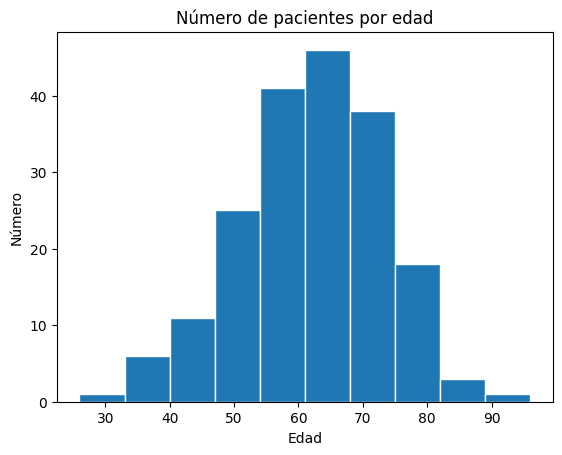

In [37]:
# Hago un gráfico de distribución pacientes por edad y sexo

fig, ax = plt.subplots()
ax.hist(df_heart['Age'], edgecolor = "white")

# Add title and axis names
plt.title('Número de pacientes por edad')
plt.xlabel('Edad')
plt.ylabel('Número') 
fig.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9604\1856740096.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


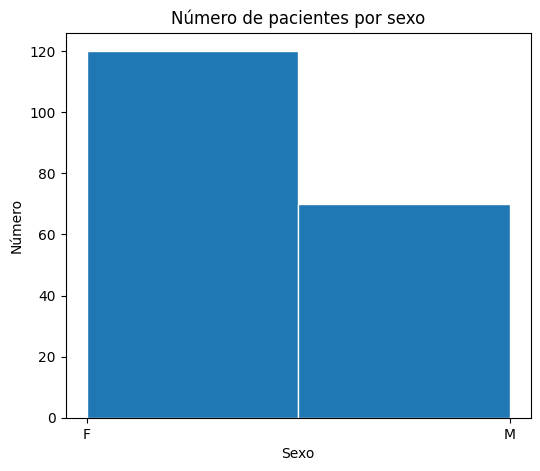

In [36]:
# Número de pacientes por sexo
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(df_heart['Sex'],bins=2,edgecolor = "white")

# Add title and axis names
plt.title('Número de pacientes por sexo')
plt.xlabel('Sexo')
plt.ylabel('Número') 
fig.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9604\1906838447.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


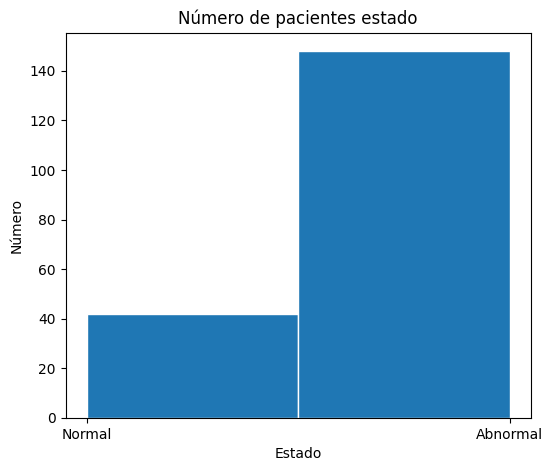

In [40]:
# Número de pacientes por enfermedad
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(df_heart['Evaluation'],bins=2,edgecolor = "white")

# Add title and axis names
plt.title('Número de pacientes estado')
plt.xlabel('Estado')
plt.ylabel('Número') 
fig.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9604\3596423459.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


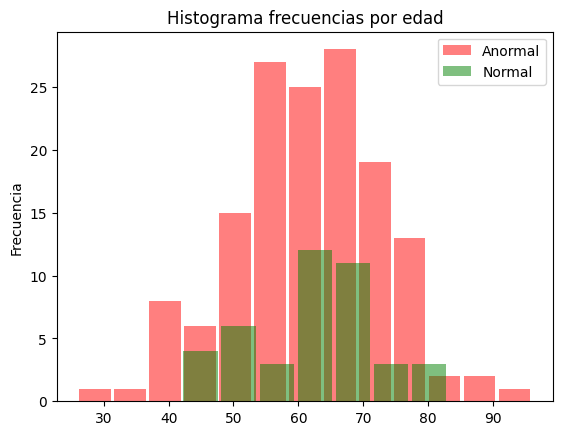

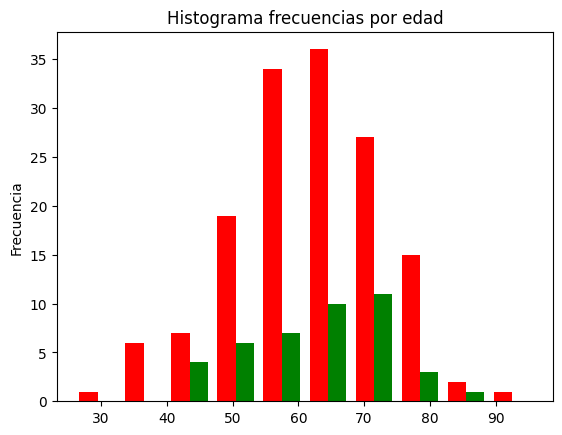

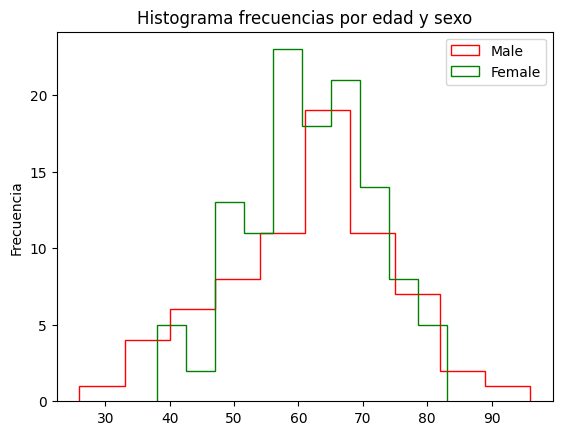

In [57]:
# Hago un gráfico de disribución de enfermedad por edad y lo solapo
# con otro gráfico igual donde no hay ocurrencia de la enfermedad

# Los histogramas son los siguientes:

x11 = df_heart.loc[df_heart['Evaluation'] == 'Abnormal',['Age']]['Age']
x12 = df_heart.loc[df_heart['Evaluation'] == 'Normal',['Age']]['Age']

plt.hist(x=x11, bins='auto', color='r',
                             alpha=0.5, rwidth=0.90, label='Anormal')

plt.hist(x=x12, bins='auto', color='g',
                             alpha=0.5, rwidth=0.90, label='Normal')
plt.gca().set(title='Histograma frecuencias por edad', ylabel='Frecuencia')
plt.legend()
fig.show()

# Otro
x=[x11.tolist(),x12.tolist()]
fig, ax = plt.subplots()
ax.hist(x, color = ["red", "green"])
ax.set(title='Histograma frecuencias por edad', ylabel='Frecuencia')
plt.show()

# Histograma por edad y sexo

m11 = df_heart.loc[df_heart['Sex'] == 'M',['Age']]['Age']
m12 = df_heart.loc[df_heart['Sex'] == 'F',['Age']]['Age']

m=[m11.tolist(),m12.tolist()]
fig, ax = plt.subplots()
ax.hist(m11, color='red', histtype='step', label='Male')
ax.hist(m12, color='green',histtype='step', label='Female')
ax.legend(loc='upper right')
ax.set(title='Histograma frecuencias por edad y sexo', ylabel='Frecuencia')
plt.show()



C:\Users\Usuario\AppData\Local\Temp\ipykernel_9604\3211073778.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


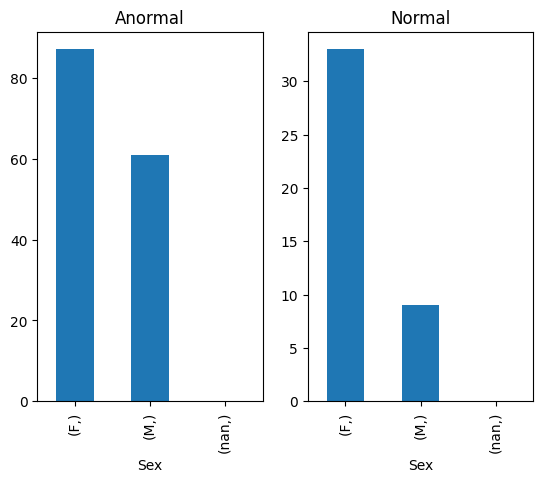

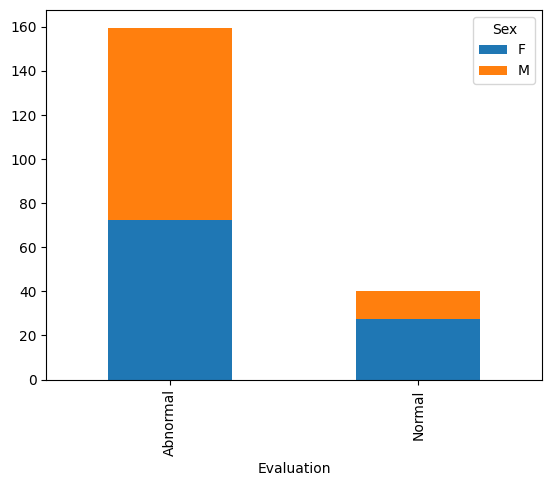

In [43]:
# Para la variable sexo se puede ver estas distribuciones
y11 = df_heart.loc[df_heart['Evaluation'] == 'Abnormal',['Sex']]
y12 = df_heart.loc[df_heart['Evaluation'] == 'Normal',['Sex']]

fig, ax = plt.subplots(1, 2)
y11.value_counts().plot(kind="bar",ax=ax[0]).set_title('Anormal')
y12.value_counts().plot(kind="bar",ax=ax[1]).set_title('Normal')  
fig.show()

# Gráficos apilados
plot = pd.crosstab(index=df_heart['Evaluation'],
            columns=df_heart['Sex']
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True)
#plot.title="Gráfica apliada de pacientes por enfermedad"

En estas gráficas se puede ver que los hombres tienden a sufrir mas las enfermedades de corazón.

## Evaluación de la independencia de las variables



In [40]:
# Evaluo si las variables categóricas Sex y Evaluation estan relacionadas
# Para ello les hago el test de Chi-Square
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import chi2

# Primero calculo la tabla de referencias cruzadas de Sexo y Evaluation
ct_table_ind=pd.crosstab(df_heart["Sex"],df_heart["Evaluation"])
print('contingency_table :\n',ct_table_ind)


contingency_table :
 Evaluation  Abnormal  Normal
Sex                         
F                 87      33
M                 61       9


In [42]:
# Para ver la independencia de dos variables categóricas se puede aplicar el test de Chi-square
# En este test se ha de rechazar la hipótesi nula de que ambas variables no estan relacionadas
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)

print(f" Valor del estadístico chi2:     {chi2_stat:.5g}")
print(f" p-value:            {p:.5g}")
print(f" grados de libertad: {dof}")
print("  frecuencias esperadas:\n",expected)

critical_value= chi2.ppf(q = 0.95, # Valor crítico para un nivel de confianza dle 95%
                         df = 1)    # df= grados de libertad
print(" Valor critico : " + str(critical_value))


 Valor del estadístico chi2:     4.6876
 p-value:            0.03038
 grados de libertad: 1
  frecuencias esperadas:
 [[93.47368421 26.52631579]
 [54.52631579 15.47368421]]
 Valor critico : 3.841458820694124


El valor crítico del test de Chi-Cuadrado con un grado de libertad y un nivel de confianza del 95% es 3,84.   
Este valor se puede consultar en cualquier tabla. Dado que el valor del test del estadístico (4.6876) excede al valor crítico 3.48 y p-value es menor a 0.5 la hipótesis nula se  
rechaza con lo que se demuestra que existe una dependencia. **El sexo afectará el resultado.**

In [43]:
# Ahora evaluo la dependencia de la enfermedad con la edad
# Primero calculo la tabla de referencias cruzadas de Age y Evaluation
ct_table_ind2=pd.crosstab(df_heart["Age"],df_heart["Evaluation"])
print('contingency_table :\n',ct_table_ind2)



contingency_table :
 Evaluation  Abnormal  Normal
Age                         
26.0               1       0
34.0               1       0
37.0               1       0
38.0               2       0
39.0               2       0
40.0               2       0
41.0               1       0
42.0               0       2
43.0               1       1
44.0               1       0
45.0               2       0
46.0               0       1
47.0               2       0
48.0               3       0
49.0               4       1
50.0               4       1
51.0               2       1
52.0               2       2
53.0               2       1
54.0               3       0
55.0               5       2
56.0               5       1
57.0               5       0
58.0               7       0
59.0               4       0
60.0               5       4
61.0               6       1
62.0               3       2
63.0               7       3
64.0               8       2
65.0               3       0
66.0               3  

In [44]:
# Para ver la independencia de dos variables categóricas se puede aplicar el test de Chi-square
# En este test se ha de rechazar la hipótesi nula de que ambas variables no estan relacionadas
chi2_stat2, p2, dof2, expected2 = scipy.stats.chi2_contingency(ct_table_ind2)

print(f" Valor del estadístico chi2:     {chi2_stat2:.5g}")
print(f" p-value:            {p2:.5g}")
print(f" grados de libertad: {dof2}")
print("  frecuencias esperadas:\n",expected2)


critical_value= chi2.ppf(q = 0.95, # Valor crítico para un nivel de confianza dle 95%
                         df = 50)    # df= grados de libertad
print(" Valor critico : " + str(critical_value))

 Valor del estadístico chi2:     47.8
 p-value:            0.56212
 grados de libertad: 50
  frecuencias esperadas:
 [[0.77894737 0.22105263]
 [0.77894737 0.22105263]
 [0.77894737 0.22105263]
 [1.55789474 0.44210526]
 [1.55789474 0.44210526]
 [1.55789474 0.44210526]
 [0.77894737 0.22105263]
 [1.55789474 0.44210526]
 [1.55789474 0.44210526]
 [0.77894737 0.22105263]
 [1.55789474 0.44210526]
 [0.77894737 0.22105263]
 [1.55789474 0.44210526]
 [2.33684211 0.66315789]
 [3.89473684 1.10526316]
 [3.89473684 1.10526316]
 [2.33684211 0.66315789]
 [3.11578947 0.88421053]
 [2.33684211 0.66315789]
 [2.33684211 0.66315789]
 [5.45263158 1.54736842]
 [4.67368421 1.32631579]
 [3.89473684 1.10526316]
 [5.45263158 1.54736842]
 [3.11578947 0.88421053]
 [7.01052632 1.98947368]
 [5.45263158 1.54736842]
 [3.89473684 1.10526316]
 [7.78947368 2.21052632]
 [7.78947368 2.21052632]
 [2.33684211 0.66315789]
 [2.33684211 0.66315789]
 [6.23157895 1.76842105]
 [8.56842105 2.43157895]
 [3.11578947 0.88421053]
 [4.6736

El valor crítico del test de Chi-Cuadrado con 50 grados de libertad y un nivel de confianza del 95% es 67,504. Este valor se puede consultar en cualquier tabla.  
Dado que el valor del test estadístico (47.8) es inferior al valor crítico (67,504) y p-value es superior a 0.5 la hipótesis nula se acepta y no se detecta ninguna dependencia con la edad.  
**Es por ello que el termino de la edad no interferirá en el resultado**.

E:\ANACONDA3\envs\Medicina_Espec\Lib\site-packages\dython\nominal.py:736: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
E:\ANACONDA3\envs\Medicina_Espec\Lib\site-packages\dython\nominal.py:737: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


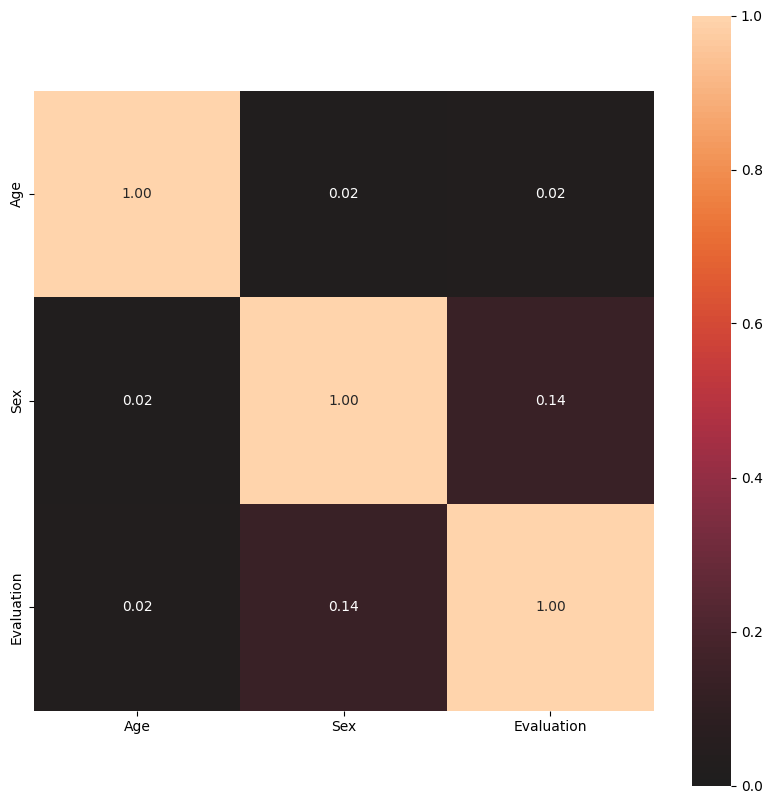

In [45]:
# Usando la libreria dyton se pueden ver las correlaciones entre las variables categóricas y numéricas
categorical_correlation= associations(df_heart, filename= 'categorical_correlation.png', figsize=(10,10))

### 2.2. Anàlisis de las carpetas de las imágenes

In [47]:
from IPython.display import Image

# Pel conjunt de dades
def contClases(directory):
    with os.scandir(directory) as dir_list :
        for entry in dir_list:            
            if os.path.isdir(entry):                               
                print("Clase: "+ 
                      entry.name +
                      " -->Longitut:" + str(len([name for name in os.listdir(entry.path) 
                                                 if os.path.isfile(os.path.join(entry.path, name))])))                      
print("Train:")    
contClases(WorkDir + "/TrainSet")
print("\n")    
print("Validation:")    
contClases(WorkDir + "/ValidationSet")
print("\n")    
print("Test:")    
contClases(WorkDir + "/TestSet")
print("\n")    

Train:
Clase: Abnormal -->Longitut:100
Clase: Normal -->Longitut:28


Validation:
Clase: Abnormal -->Longitut:25
Clase: Normal -->Longitut:7


Test:
Clase: Abnormal -->Longitut:25
Clase: Normal -->Longitut:7





 Fitxer : E:/Formacion_UOC/TFM Medicina personalizada/DESARROLLO_PROYECTO/Fuente de datos/TrainSet\Abnormal\2001.jpg
RGB shape: (897, 976, 3)
ARGB shape: (897, 976, 3)
Gray shape: (897, 976)
img.dtype: uint8
img.size: 2626416
long: 100

 Fitxer : E:/Formacion_UOC/TFM Medicina personalizada/DESARROLLO_PROYECTO/Fuente de datos/TrainSet\Normal\1001.jpg
RGB shape: (897, 976, 3)
ARGB shape: (897, 976, 3)
Gray shape: (897, 976)
img.dtype: uint8
img.size: 2626416
long: 28

 Rang dinàmic RGB : [0,255]


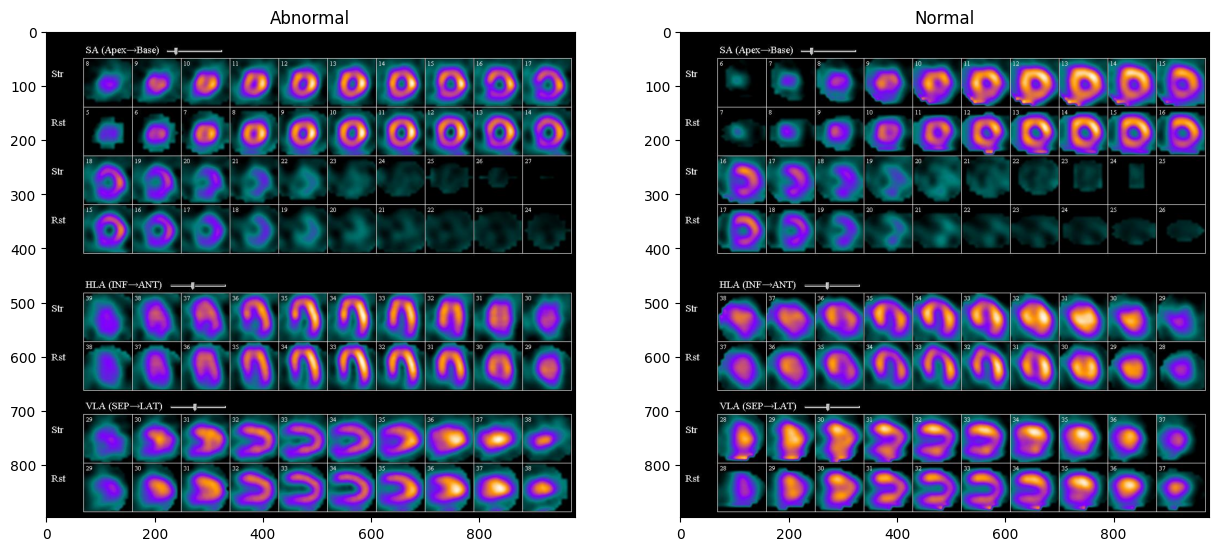

In [48]:
# Visualizo las imagenes

from IPython.display import display
from PIL import Image

#
def drawImages(directory):
    maxValTot = 0
    minValTot = 0
    with os.scandir(directory) as dir_list :    
        count = 0
        fig, ax = plt.subplots(1, 2, figsize=(15,7))
        for entry in dir_list:            
            if os.path.isdir(entry):            
                fileList = [os.path.join(entry.path, name) for name in os.listdir(entry.path) 
                            if os.path.isfile(os.path.join(entry.path, name))]
                # Miro el primer fitxer del grup
                if (len(fileList) >0):
                    img_file = fileList[0]                                                            
                    ## Obtinc el format
                    img = cv2.imread(img_file, cv2.IMREAD_COLOR)           # rgb
                    alpha_img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED) # rgba
                    gray_img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)  # grayscale
                    ##                    
                    print("\n Fitxer : "+ img_file)
                    print("RGB shape:", img.shape)        # Rows, cols, channels
                    print ("ARGB shape:", alpha_img.shape)
                    print ("Gray shape:", gray_img.shape)
                    print ("img.dtype:", img.dtype)
                    print ("img.size:", img.size)
                    print ("long:",len(fileList))
                                        
                    ax = plt.subplot(1, 2, count + 1)     
                    ax.title.set_text(entry.name)
                    img2 = np.asarray(Image.open(img_file))
                    imgplot = plt.imshow(img2)
                    count = count + 1
                    
                                        
                    # Obtenir el màxim i mínim d'una imatge
                    rows,cols,_ = img.shape                    
                    for i in range(rows):
                        for j in range(cols):
                            k = img[i,j]
                            arr = np.array(k)                            
                            maxValArr = np.max(arr)
                            minValArr = np.min(arr)
                            if (maxValArr > maxValTot):
                                maxValTot = maxValArr                            
                            if (minValArr < minValTot):
                                minValArr = minValArr                            

    
    print("\n Rang dinàmic RGB : [" + str(minValTot) + "," + str(maxValTot) + "]" )                
                    

# Visualizo las distintas categorias de los datos de test
drawImages(WorkDir + "/TrainSet")



### 2.2. Balance y aumentación de las imagenes  

Las imagenes que exiten no estan balanceadas, en el sentido de que hay mas mujeres que hombres que han realizado la prueba.  
Dado que el peso que tiene el sexo en el resultado del del test no es menospreciable se han de balancer las imagenes para que durante el entremaniento  
los modelos acusen el problema de estar sesgados por el sexo.  
Dado que no se ha podido mostrar que la edad repercuta diréctamente en el resultado final este parámetro se eliminará de los modelos que   
se entrenaran a posteriori.  

In [50]:
# Inventariado de imagenes
# Hago un inventario de imagenes agrupadas por paciente, sexo y carpeta.
# El objetivo es balancear las imagenes añadiendo duplicados de manera aleatoria

# Voy a realizar lo que se llama Random Oversampling de las clase minoritaria de Male (F)
# Esta técnica solo se aplicará sobre los datos de la carpeta de entrenamiento, no se aplicará sobre
# los datos de la carpeta de validación y test.

# check version number
import imblearn

# Get data frame
def getImageList(directory):            
    dir_list  = os.scandir(directory)
    for entry in dir_list: 
        fileList = [[name, entry.path, name.replace(".jpg", "")] for name in os.listdir(entry.path) 
                    if os.path.isfile(os.path.join(entry.path, name))]        
       
    df_image = pd.DataFrame(fileList, columns =['Name', 'Path','Patient'])                  
    df_image = df_image.sort_values('Name')
    return df_image

df_train_files = getImageList(WorkDir + "/TrainSet")
df_train_files.head(10)


Name                                               Path Patient
0  1001.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1001
1  1002.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1002
2  1003.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1003
3  1004.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1004
4  1005.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1005
5  1006.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1006
6  1007.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1007
7  1008.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1008
8  1009.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1009
9  1010.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1010

In [51]:
# Completo esta tabla con los datos del sexo
df_trainfiles_merge = df_train_files.merge(dfList_Ini, on='Patient', how='left')
df_trainfiles_merge.head(10)


Name                                               Path Patient    No  \
0  1001.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1001   1.0   
1  1002.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1002   2.0   
2  1003.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1003   3.0   
3  1004.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1004   4.0   
4  1005.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1005   5.0   
5  1006.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1006   6.0   
6  1007.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1007   7.0   
7  1008.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1008   8.0   
8  1009.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1009   9.0   
9  1010.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1010  10.0   

    Age Sex Evaluation Set Distribution  
0  69.0   F     Normal            Train  
1  60.0   F     Normal            Train  
2  49.0   M     Normal            Train  
3  68.0   F     Normal            Train  
4  60.0   F     Normal            Train  
5  68.0   F     Normal            Train  
6  83.0   F     Normal            Train  
7  60.0   F     Normal            Train  
8  56.0   F     Normal            Train  
9  68.0   F     Normal            Train

In [52]:
# Número de instancias por sexo
NumValues = df_trainfiles_merge.groupby(['Sex'],observed=False)['Sex'].count()
print("Total por enfermedad: \n")
print(NumValues)

Total por enfermedad: 

Sex
F      25
M       3
nan     0
Name: Sex, dtype: int64


In [54]:
# Oversampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
# Defino la estrategia de las muestras
oversample = RandomOverSampler(sampling_strategy='minority')
# Se introduce y se transforma
print('Numero filas antes: ' + str(len(df_trainfiles_merge)))
df_trainOverSamp, y_over = oversample.fit_resample(df_trainfiles_merge, df_trainfiles_merge['Sex'])
print('Numero filas despues: ' + str(len(df_trainOverSamp)))
# summarize class distribution
df_trainOverSamp.tail(90)


Numero filas antes: 28
Numero filas despues: 50


Name                                               Path Patient    No  \
0   1001.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1001   1.0   
1   1002.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1002   2.0   
2   1003.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1003   3.0   
3   1004.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1004   4.0   
4   1005.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1005   5.0   
5   1006.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1006   6.0   
6   1007.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1007   7.0   
7   1008.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1008   8.0   
8   1009.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1009   9.0   
9   1010.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1010  10.0   
10  1011.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1011  11.0   
11  1012.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1012  12.0   
12  1013.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1013  13.0   
13  1016.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1016  16.0   
14  1020.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1020  20.0   
15  1021.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1021  21.0   
16  1023.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1023  23.0   
17  1024.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1024  24.0   
18  1025.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1025  25.0   
19  1027.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1027  27.0   
20  1030.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1030  30.0   
21  1031.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1031  31.0   
22  1032.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1032  32.0   
23  1033.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1033  33.0   
24  1035.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1035  35.0   
25  1038.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1038  38.0   
26  1040.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1040  40.0   
27  1042.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1042  42.0   
28  1035.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1035  35.0   
29  1003.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1003   3.0   
30  1035.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1035  35.0   
31  1035.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1035  35.0   
32  1027.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1027  27.0   
33  1027.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1027  27.0   
34  1035.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1035  35.0   
35  1003.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1003   3.0   
36  1027.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1027  27.0   
37  1027.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1027  27.0   
38  1035.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1035  35.0   
39  1035.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1035  35.0   
40  1027.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1027  27.0   
41  1035.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1035  35.0   
42  1035.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1035  35.0   
43  1027.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1027  27.0   
44  1035.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1035  35.0   
45  1027.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1027  27.0   
46  1003.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1003   3.0   
47  1003.jpg  E:/Formacion_UOC/TFM Medicina personalizada/DE...    1003   3.0   
48  1003.jpg  E:/Formacion_UOC/TFM Medi

In [55]:
# Número de instancias por sexo
NumValues = df_trainOverSamp.groupby(['Sex'],observed=False)['Sex'].count()
print("Total por enfermedad: \n")
print(NumValues)

Total por enfermedad: 

Sex
F      25
M      25
nan     0
Name: Sex, dtype: int64


In [80]:
# Guardar los ficheros procesados
import shutil

# Borrar ficheros del directorio
def delete_directory(directory_path):
    try:
        files = os.listdir(directory_path)
        for file in files:
            file_path = os.path.join(directory_path, file)
            if os.path.isfile(file_path):
                   os.remove(file_path)        
    except OSError:
        print("Error al borrar ficheros")
        
# clear directory
delete_directory(WorkDir2 + "/Abnormal")    

# Generar ficheros balanceados       
Num = 1
for indice_fila, row in df_trainOverSamp.iterrows():    
    fullName =  row['Path'] + "/" + row['Name']
    evaluation = row['Evaluation']  
    # Names
    name = row['Name'].split(".")[0]    
    nameTo =  name + "_" + str(Num) + "S.jpg"    
    print(nameTo)
    # Create folder
    path2 = os.path.join(WorkDir2, evaluation) 
    isExist = os.path.exists(path2)    
    if (isExist is False ) :
        os.mkdir(path2)     
    # Copy         
    shutil.copy(fullName, WorkDir2 + "\\" + evaluation + "\\" + nameTo)            
    Num = Num + 1
    
	

Error al borrar ficheros
1001_1S.jpg
1002_2S.jpg
1003_3S.jpg
1004_4S.jpg
1005_5S.jpg
1006_6S.jpg
1007_7S.jpg
1008_8S.jpg
1009_9S.jpg
1010_10S.jpg
1011_11S.jpg
1012_12S.jpg
1013_13S.jpg
1016_14S.jpg
1020_15S.jpg
1021_16S.jpg
1023_17S.jpg
1024_18S.jpg
1025_19S.jpg
1027_20S.jpg
1030_21S.jpg
1031_22S.jpg
1032_23S.jpg
1033_24S.jpg
1035_25S.jpg
1038_26S.jpg
1040_27S.jpg
1042_28S.jpg
1035_29S.jpg
1003_30S.jpg
1035_31S.jpg
1035_32S.jpg
1027_33S.jpg
1027_34S.jpg
1035_35S.jpg
1003_36S.jpg
1027_37S.jpg
1027_38S.jpg
1035_39S.jpg
1035_40S.jpg
1027_41S.jpg
1035_42S.jpg
1035_43S.jpg
1027_44S.jpg
1035_45S.jpg
1027_46S.jpg
1003_47S.jpg
1003_48S.jpg
1003_49S.jpg
1027_50S.jpg


In [81]:
# Crear imagenes a las que reduzco el brillo y el contraste

from PIL import Image, ImageEnhance
import cv2

# Generar ficheros        
Num = 1
for indice_fila, row in df_trainOverSamp.iterrows():
    fullName =  row['Path'] + "/" + row['Name']
    evaluation = row['Evaluation']          
    
    # Selecciono ficheros y reduzco el brillo un 25 %
    # Names
    name = row['Name'].split(".")[0]
    nameTo =  name + "_" + str(Num) + "B.jpg"        
    im1 =  Image.open(fullName)
    enhancer1 = ImageEnhance.Brightness(im1)
    im2 = enhancer1.enhance(0.75)    
    im2.save(WorkDir2 + "/" + evaluation + "/" + nameTo)     
    
    # Selecciono ficheros y reduzco el contraste un 25%   
    name = row['Name'].split(".")[0]  
    nameTo =  name + "_" + str(Num) + "C.jpg"            
    enhancer2 = ImageEnhance.Contrast(im1)
    im3 = enhancer2.enhance(0.75)  
    im2.save(WorkDir2 + "/" + evaluation + "/" + nameTo)         
    
    # Generar ficher con ruido Gaussiano y se lo añado a la imagen
    #  μ = 0, σ = 20, size = length of x or y.                 
    im4 = cv2.imread(fullName)        
    # Genearte noise with same shape as that of the image
    noise = np.random.normal(0, 20, im4.shape) 
    # Add the noise to the image
    img_noised = im4 + noise
    # Clip the pixel values to be between 0 and 255.
    img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)
    name = row['Name'].split(".")[0]      
    nameTo =  name + "_" + str(Num) + "N.jpg"            
    cv2.imwrite(WorkDir2 + "/" + evaluation + "/" + nameTo, img_noised) 
    
    Num = Num + 1    
    

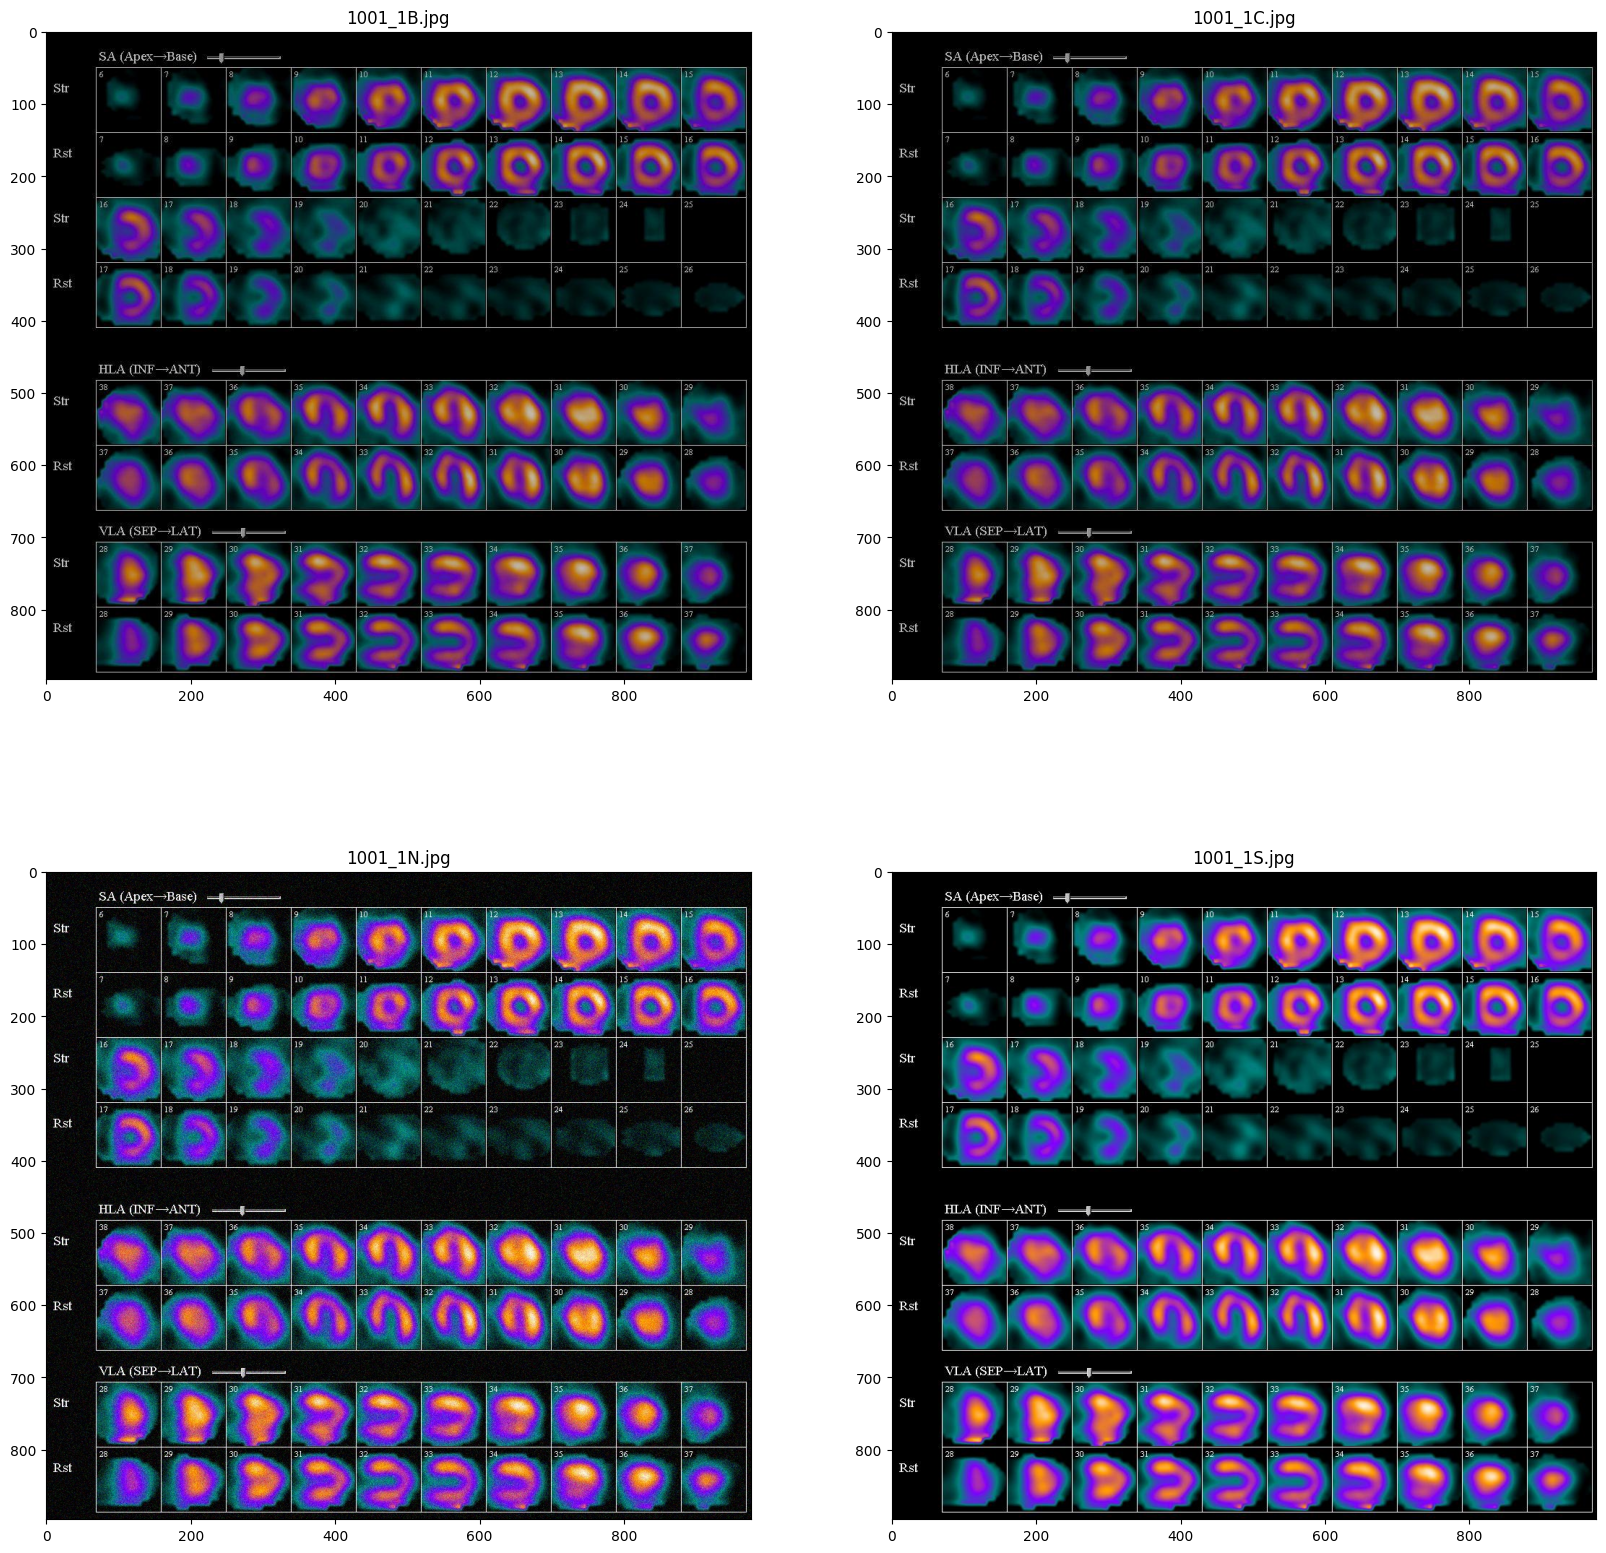

In [82]:
# Muestro un ejemplo de 3 imagenes generadas

##    
fig, ax = plt.subplots(2, 2, figsize=(20,20))
df_workImages = getImageList(WorkDir2)
for ind in range(0,4) : 
    row = df_workImages.iloc[ind]    
    fullName =  row['Path'] + "/" + row['Name']            
    ax = plt.subplot(2, 2, ind + 1 )    
    ax.title.set_text(row['Name'] )
    img2 = np.asarray(Image.open(fullName))
    imgplot = plt.imshow(img2)
    
